## Phase 4c: 

Mainly:
- Deep Learning Models - using a LSTM model with TensorFlow
- Idea is to see how an unsupervised learning model affects the scores (if any).

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import datetime as dt
import os
import time
import itertools
import random

from tqdm import tqdm # a progress bar
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Load Data From Script

In [2]:
# Import the data loading script that's in this directory too (data in psql local server)
import load_data_models as data

btc_ta = data.btc_ta
eth_ta = data.eth_ta
ltc_ta = data.ltc_ta
xlm_ta = data.xlm_ta
dash_ta = data.dash_ta
link_ta = data.link_ta

Available data:     tablename
0     BTCUSD
1     BTC_TA
2    DASHUSD
3    DASH_TA
4     ETHUSD
5     ETH_TA
6    LINKUSD
7    LINK_TA
8     LTCUSD
9     LTC_TA
10    XLMUSD
11    XLM_TA
Data Loaded. For now just add for example btc_ta = data_loading_phase_4.btc_ta as a variable for your data.


## TensorFlow + Keras Model

### 1: Binary Classifier

In [3]:
# Import a DL framework

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint # To save models
checkpoint_filepath = '/Users/marzimin/OneDrive/test-projects/'

### LOAD & PREPROCESS DATA

In [4]:
# Make train and test sets (based on time)
# Keeping close and volume, but drop OHL, and target

def preprocess(df, periods=1):

    """ Preprocesses coin data for DL models. Add configurable future periods (hours for our case)
    to predict in the dataset. Defaults to 1 hour in the future."""

 
    # 'close' and TI's shifted
    try:
        df['next_close'] = df['close'].shift(-periods)
        df['target'] = np.where(df['next_close'] > df['close'], 1, 0)
        mask = ~(df.columns.isin(['open','high', 'low']))
        shift_cols = df.columns[mask]
        df2 = df.copy()
        pre_X = df2.loc[:,mask].shift(-periods)
        pre_X.drop(columns=['next_close'], inplace=True) # Need to drop shifted price columns too
    
    except:
        print("Please place a time indexed OHLCV DataFrame")

    X = pre_X.dropna(how='any')
    y = X.pop('target')

    cols = X.columns

    # Most recent 20% of data the test sets
    X_train, X_test= np.split(X, [int(.80 *len(X))])
    y_train, y_test= np.split(y, [int(.80 *len(X))])

    # Min max scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    # Input for TF/Keras models (needs a 3-Dimensional Input)
    # The below adds another dimension to your 2D DataFrame
    X_train_input = np.expand_dims(X_train_sc, 1)
    X_test_input = np.expand_dims(X_test_sc, 1)
    
    return X_train_sc, X_test_sc, X_train_input, X_test_input, y_train, y_test

### Train / test sets (scaled)

In [5]:
btc_tr, btc_ts, btc_iptr, btc_ipts, btc_ytr, btc_yts = preprocess(btc_ta)

### See ouput examples:

In [6]:
btc_tr.head()

,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,-0.970044,-0.985000,-0.639339,-0.677421,0.505734,0.422845,0.369241,0.073325,0.218659,-0.123776,-0.999806,-0.970239,-0.995776,-0.970442,-0.971391,-0.969703,-0.922227,0.289441,-1.0,-1.0,-0.970300,-0.971214,-0.969559,-0.954599,0.044800,-1.0,-1.0,-0.952408,-0.971092,-0.970423,-0.959079,0.727145,-0.973032,0.252262,0.234009,-0.007232,-0.970231,-0.970688,-0.970304,-0.970527,-0.601879,-0.378773,-0.661531,-0.872964,-0.235655,-0.829329,0.982407,0.302400,0.163189,-0.448276,0.636282,0.639139,-0.357961,-0.970086,-0.970666,-0.970372,-0.970701,-0.970814,-0.970447,0.833333,-0.916667,0.875000,-0.952123,-0.954375,-1.0,-1.0,0.999982,0.193175,0.256410,0.554752,0.753924,0.267209,0.333226,0.726889,0.810708,0.726889,0.254761,-0.970391,-0.038452,-0.323942,-0.276489,-0.327125,0.618472,-0.033192,-0.970044
1,-0.970168,-0.989075,-0.639402,-0.677988,0.382164,0.422821,0.282294,0.073333,0.218647,-0.123704,-0.999807,-0.970220,-0.995705,-0.970418,-0.971376,-0.969671,-0.923558,0.158439,-1.0,-1.0,-0.970271,-0.971173,-0.969545,-0.950778,-0.081930,-1.0,-1.0,-0.952407,-0.971092,-0.970423,-0.959142,0.488503,-0.972232,0.252102,0.234115,-0.007965,-0.970195,-0.970670,-0.970300,-0.970512,-0.600181,-0.425637,-0.648873,-0.869254,-0.196179,-0.829367,0.982457,0.311172,0.122821,-0.447746,0.636778,0.641077,-0.364628,-0.970086,-0.970666,-0.970372,-0.970701,-0.970775,-0.970447,0.750000,-1.000000,0.875000,-0.952052,-0.954375,-1.0,-1.0,0.999991,0.112536,-0.381299,0.094319,0.483895,0.259971,0.301056,0.334554,0.588499,0.334554,0.254822,-0.970387,-0.047040,-0.350736,-0.261237,-0.389868,0.613544,-0.047980,-0.970168
2,-0.970158,-0.987375,-0.639450,-0.677334,0.289233,0.422820,0.189426,0.073343,0.218580,-0.123706,-0.999807,-0.970205,-0.995947,-0.970403,-0.971359,-0.969658,-0.923158,0.152196,-1.0,-1.0,-0.970261,-0.971172,-0.969525,-0.953203,-0.083874,-1.0,-1.0,-0.952407,-0.971092,-0.970423,-0.959156,0.506335,-0.971830,0.251960,0.234169,-0.008510,-0.970169,-0.970642,-0.970295,-0.970497,-0.598604,-0.442871,-0.659408,-0.877379,-0.132698,-0.843486,0.982488,0.312476,0.100460,-0.447340,0.636286,0.642781,-0.374815,-0.970086,-0.970666,-0.970372,-0.970835,-0.970878,-0.970447,0.666667,-0.916667,0.791667,-0.951991,-0.954375,-1.0,-1.0,0.999996,0.117342,-0.353987,-0.159625,0.163149,0.254662,0.238551,0.312867,0.457141,0.312867,0.254706,-0.970386,-0.055356,-0.359161,-0.251313,-0.415850,0.618419,-0.033350,-0.970158
3,-0.970160,-0.992038,-0.639414,-0.677749,0.276107,0.422818,0.108909,0.073338,0.218569,-0.123640,-0.999807,-0.970185,-0.996156,-0.970393,-0.971345,-0.969652,-0.922464,0.139766,-1.0,-1.0,-0.970262,-0.971177,-0.969522,-0.954423,-0.085219,-1.0,-1.0,-0.952407,-0.971092,-0.970423,-0.959165,0.502581,-0.971298,0.251819,0.234181,-0.008942,-0.970152,-0.970

In [7]:
btc_ytr.head()

time
2017-01-01 00:00:00    0.0
2017-01-01 01:00:00    1.0
2017-01-01 02:00:00    0.0
2017-01-01 03:00:00    0.0
2017-01-01 04:00:00    1.0
Name: target, dtype: float64

In [8]:
btc_ytr.value_counts(normalize=True)

1.0    0.524788
0.0    0.475212
Name: target, dtype: float64

In [9]:
btc_yts.value_counts(normalize=True)

1.0    0.524505
0.0    0.475495
Name: target, dtype: float64

In [10]:
# preprocess other data too:

eth_tr, eth_ts, eth_iptr, eth_ipts, eth_ytr, eth_yts = preprocess(eth_ta)
ltc_tr, ltc_ts, ltc_iptr, ltc_ipts, ltc_ytr, ltc_yts = preprocess(ltc_ta)
xlm_tr, xlm_ts, xlm_iptr, xlm_ipts, xlm_ytr, xlm_yts = preprocess(xlm_ta)
dash_tr, dash_ts, dash_iptr, dash_ipts, dash_ytr, dash_yts = preprocess(dash_ta)
link_tr, link_ts, link_iptr, link_ipts, link_ytr, link_yts = preprocess(link_ta)

In [11]:
# Input shape should be all features 'flattened'
# this should be the same for all coins in this dataset

btc_iptr.shape[1:], eth_iptr.shape[1:], ltc_iptr.shape[1:], xlm_iptr.shape[1:], dash_iptr.shape[1:], link_iptr.shape[1:]

((1, 85), (1, 85), (1, 85), (1, 85), (1, 85), (1, 85))

## Models

In [12]:
# Constants for DL models

EPOCHS = 200
BATCH_SIZE = 256
    
# Set callbacks (you can add a verbose argument too)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=40, 
    restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_weights_only=True,
    monitor='val_acc', mode='max',
    save_best_only=True)

In [13]:
# Model architecture (this is configurable to your liking within the function):
# Alter shape for other types of OHLCV datasets:

def Model(shape=(1, 85)):

    """ Simply wrapping a control model in a function to use on all datasets in this notebook."""

    # Makes sure your results are replicable (like random_state)
    tf.random.set_seed(1)

    classifier = Sequential()

    classifier.add(LSTM(512, input_shape=(shape), return_sequences=True))
    classifier.add(Dropout(0.2)) # a regularization technique (mutes randomized 20% of nodes)

    classifier.add(LSTM(256, input_shape=(shape), return_sequences=True))
    classifier.add(Dropout(0.2))

    classifier.add(LSTM(128, input_shape=(shape)))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(64, activation="relu"))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(32, activation="relu"))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(16, activation="relu"))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(8, activation="relu"))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(4, activation="relu"))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(2, activation="softmax")) # output layer

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    classifier.compile(loss='sparse_categorical_crossentropy', # As this is a binary classifier (use mse for regressor)
                optimizer=opt,
                metrics=['accuracy'])

    return classifier

In [14]:
# Instantiate control model:
classifier = Model()

### BTC

In [15]:
# Run the model:

history_btc = classifier.fit(btc_iptr, btc_ytr,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(btc_ipts, btc_yts),
                    callbacks=[early_stop, model_checkpoint_callback])

 0.5448 - val_loss: 0.6858 - val_accuracy: 0.5483
Epoch 36/200
139/139 [==============================] - 7s 53ms/step - loss: 0.6840 - accuracy: 0.5549 - val_loss: 0.6865 - val_accuracy: 0.5491
Epoch 37/200
139/139 [==============================] - 8s 57ms/step - loss: 0.6856 - accuracy: 0.5469 - val_loss: 0.6865 - val_accuracy: 0.5441
Epoch 38/200
139/139 [==============================] - 8s 56ms/step - loss: 0.6859 - accuracy: 0.5490 - val_loss: 0.6866 - val_accuracy: 0.5481
Epoch 39/200
139/139 [==============================] - 8s 57ms/step - loss: 0.6869 - accuracy: 0.5471 - val_loss: 0.6860 - val_accuracy: 0.5497
Epoch 40/200
139/139 [==============================] - 8s 55ms/step - loss: 0.6851 - accuracy: 0.5472 - val_loss: 0.6856 - val_accuracy: 0.5484
Epoch 41/200
139/139 [==============================] - 8s 56ms/step - loss: 0.6850 - accuracy: 0.5515 - val_loss: 0.6864 - val_accuracy: 0.5469
Epoch 42/200
139/139 [==============================] - 8s 56ms/step - loss: 0.6

In [16]:
# Plot loss & accuracy

def plot_metrics(history_, X_iptrain, X_iptest, y_train, y_test, model=classifier):

    """ Get your Loss, Accuracy and Best Model Scores for your DL TF Models."""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.tight_layout(pad=3)
    fig.suptitle("Loss and Accuracy Scores")

    ax1.plot(history_.history['loss'], c='b')
    ax1.plot(history_.history['val_loss'], c='r') # test sets
    ax1.set_title("Model Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.legend(['Train', 'Test'], loc='upper left')

    ax2.plot(history_.history['accuracy'], c='b')
    ax2.plot(history_.history['val_accuracy'], c='r')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Accuracy")
    ax2.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    baseline_tr = y_train.value_counts(normalize=True)[1]
    baseline_ts = y_test.value_counts(normalize=True)[1]

    predictions_tr = classifier.predict(X_iptrain)
    predictions_ts = classifier.predict(X_iptest)

    print("\n Baseline Train: ", baseline_tr,"\n","Baseline Test:  ", baseline_ts)
    print("-"*40)
    print("Best Train Score: ", accuracy_score(y_train, predictions_tr.argmax(axis=1)))
    print("Best Test Score:  ", accuracy_score(y_test, predictions_ts.argmax(axis=1)))

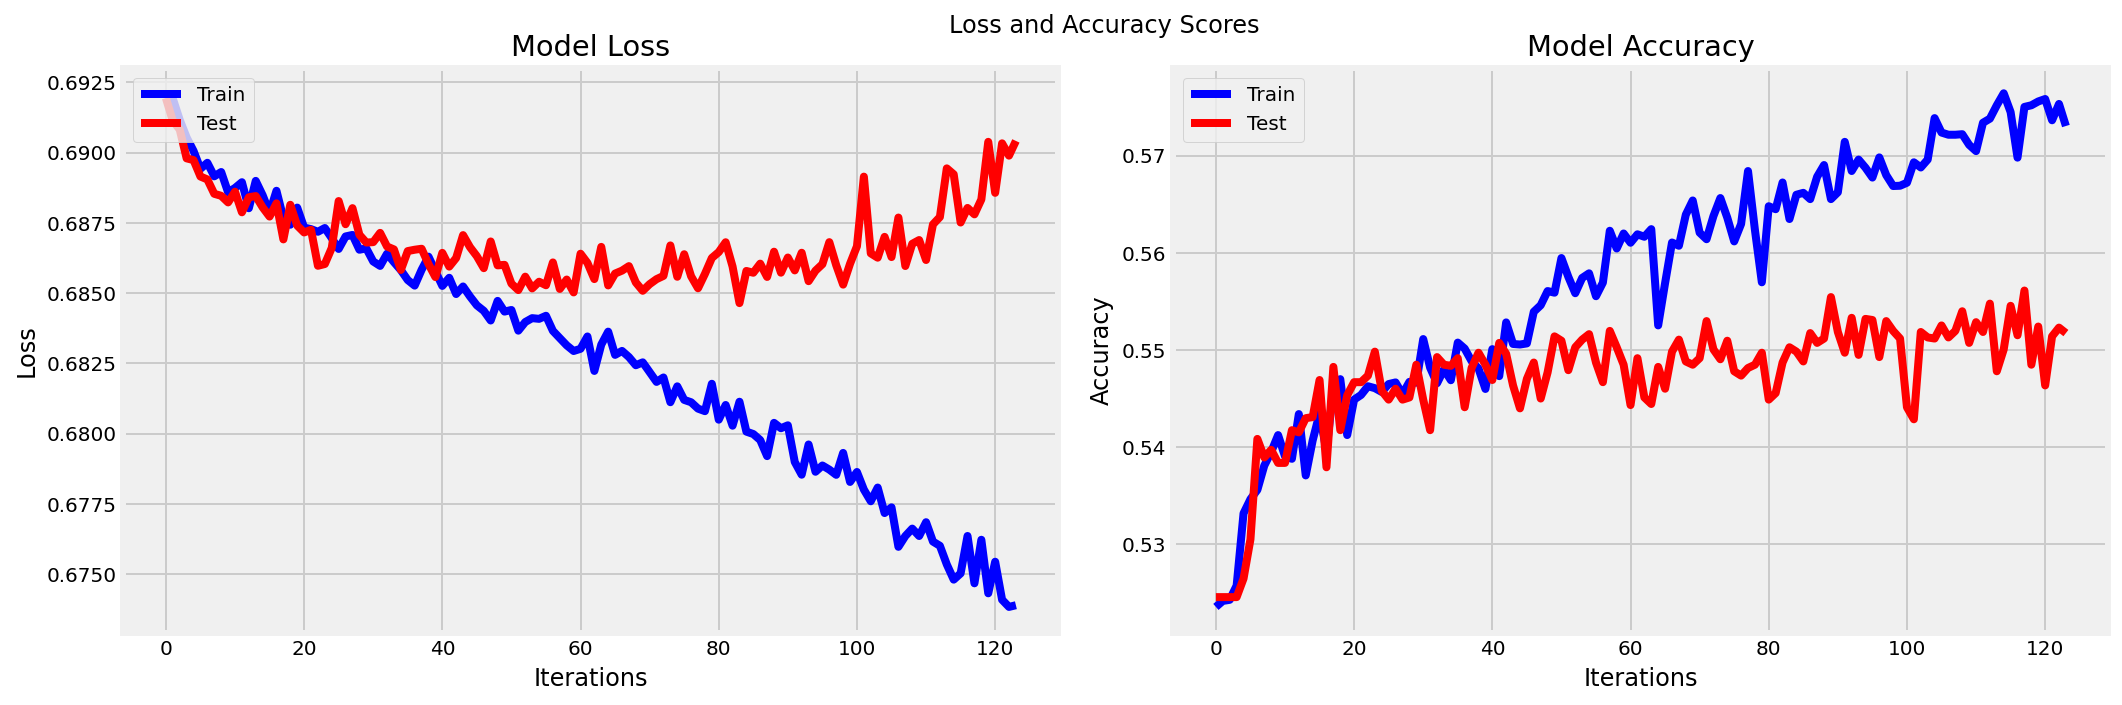


 Baseline Train:  0.5247878140632904 
 Baseline Test:   0.5245053956834532
----------------------------------------
Best Train Score:  0.5743634421898712
Best Test Score:   0.5502473021582733


In [17]:
# BTC plots and metrics:

plot_metrics(history_btc, btc_iptr, btc_ipts, btc_ytr, btc_yts)

### ETH

In [18]:
history_eth = classifier.fit(eth_iptr, eth_ytr,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(eth_ipts, eth_yts),
                    callbacks=[early_stop, model_checkpoint_callback])

Epoch 1/200
129/129 [==============================] - 7s 58ms/step - loss: 0.6907 - accuracy: 0.5364 - val_loss: 0.6895 - val_accuracy: 0.5388
Epoch 2/200
129/129 [==============================] - 7s 55ms/step - loss: 0.6892 - accuracy: 0.5405 - val_loss: 0.6888 - val_accuracy: 0.5433
Epoch 3/200
129/129 [==============================] - 7s 58ms/step - loss: 0.6885 - accuracy: 0.5428 - val_loss: 0.6886 - val_accuracy: 0.5397
Epoch 4/200
129/129 [==============================] - 7s 57ms/step - loss: 0.6883 - accuracy: 0.5452 - val_loss: 0.6882 - val_accuracy: 0.5450
Epoch 5/200
129/129 [==============================] - 7s 57ms/step - loss: 0.6880 - accuracy: 0.5462 - val_loss: 0.6887 - val_accuracy: 0.5406
Epoch 6/200
129/129 [==============================] - 7s 58ms/step - loss: 0.6878 - accuracy: 0.5454 - val_loss: 0.6882 - val_accuracy: 0.5402
Epoch 7/200
129/129 [==============================] - 7s 53ms/step - loss: 0.6869 - accuracy: 0.5471 - val_loss: 0.6878 - val_accuracy:

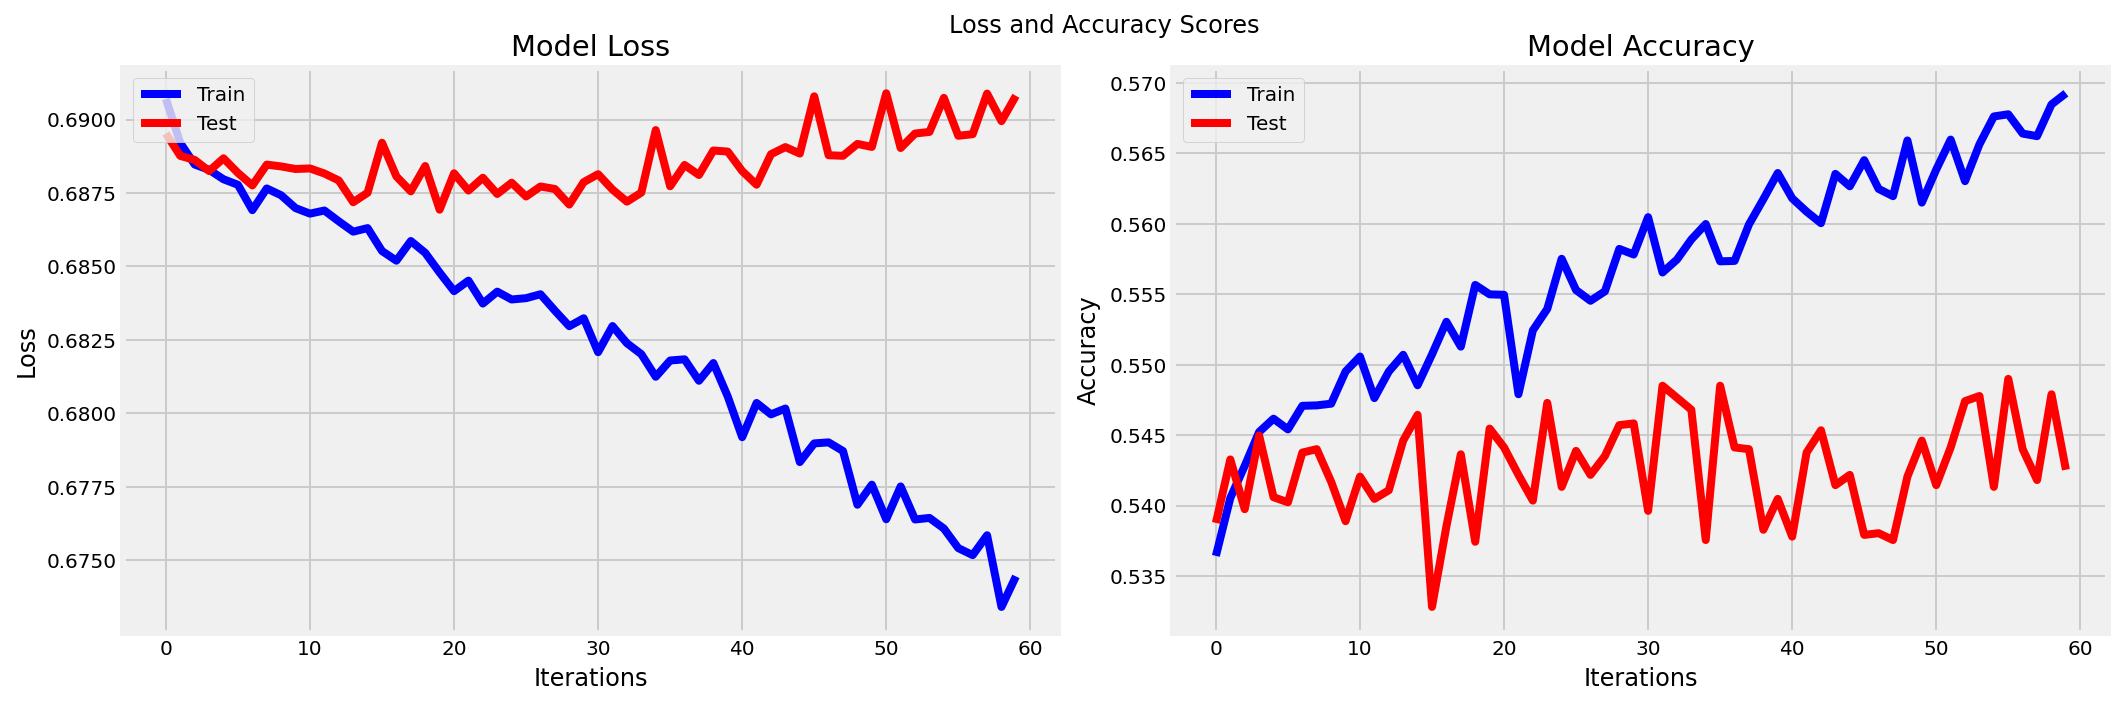


 Baseline Train:  0.4975957148943941 
 Baseline Test:   0.4910529519172246
----------------------------------------
Best Train Score:  0.5626940166778258
Best Test Score:   0.5454656116859403


In [19]:
plot_metrics(history_eth, eth_iptr, eth_ipts, eth_ytr, eth_yts)

### LTC

In [20]:
history_ltc = classifier.fit(ltc_iptr, ltc_ytr,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(ltc_ipts, ltc_yts),
                    callbacks=[early_stop, model_checkpoint_callback])

Epoch 1/200
119/119 [==============================] - 7s 57ms/step - loss: 0.6888 - accuracy: 0.5415 - val_loss: 0.6835 - val_accuracy: 0.5591
Epoch 2/200
119/119 [==============================] - 7s 58ms/step - loss: 0.6853 - accuracy: 0.5538 - val_loss: 0.6833 - val_accuracy: 0.5602
Epoch 3/200
119/119 [==============================] - 6s 54ms/step - loss: 0.6845 - accuracy: 0.5579 - val_loss: 0.6821 - val_accuracy: 0.5625
Epoch 4/200
119/119 [==============================] - 7s 56ms/step - loss: 0.6846 - accuracy: 0.5543 - val_loss: 0.6815 - val_accuracy: 0.5613
Epoch 5/200
119/119 [==============================] - 6s 53ms/step - loss: 0.6845 - accuracy: 0.5577 - val_loss: 0.6816 - val_accuracy: 0.5588
Epoch 6/200
119/119 [==============================] - 7s 55ms/step - loss: 0.6833 - accuracy: 0.5590 - val_loss: 0.6822 - val_accuracy: 0.5574
Epoch 7/200
119/119 [==============================] - 7s 55ms/step - loss: 0.6837 - accuracy: 0.5564 - val_loss: 0.6811 - val_accuracy:

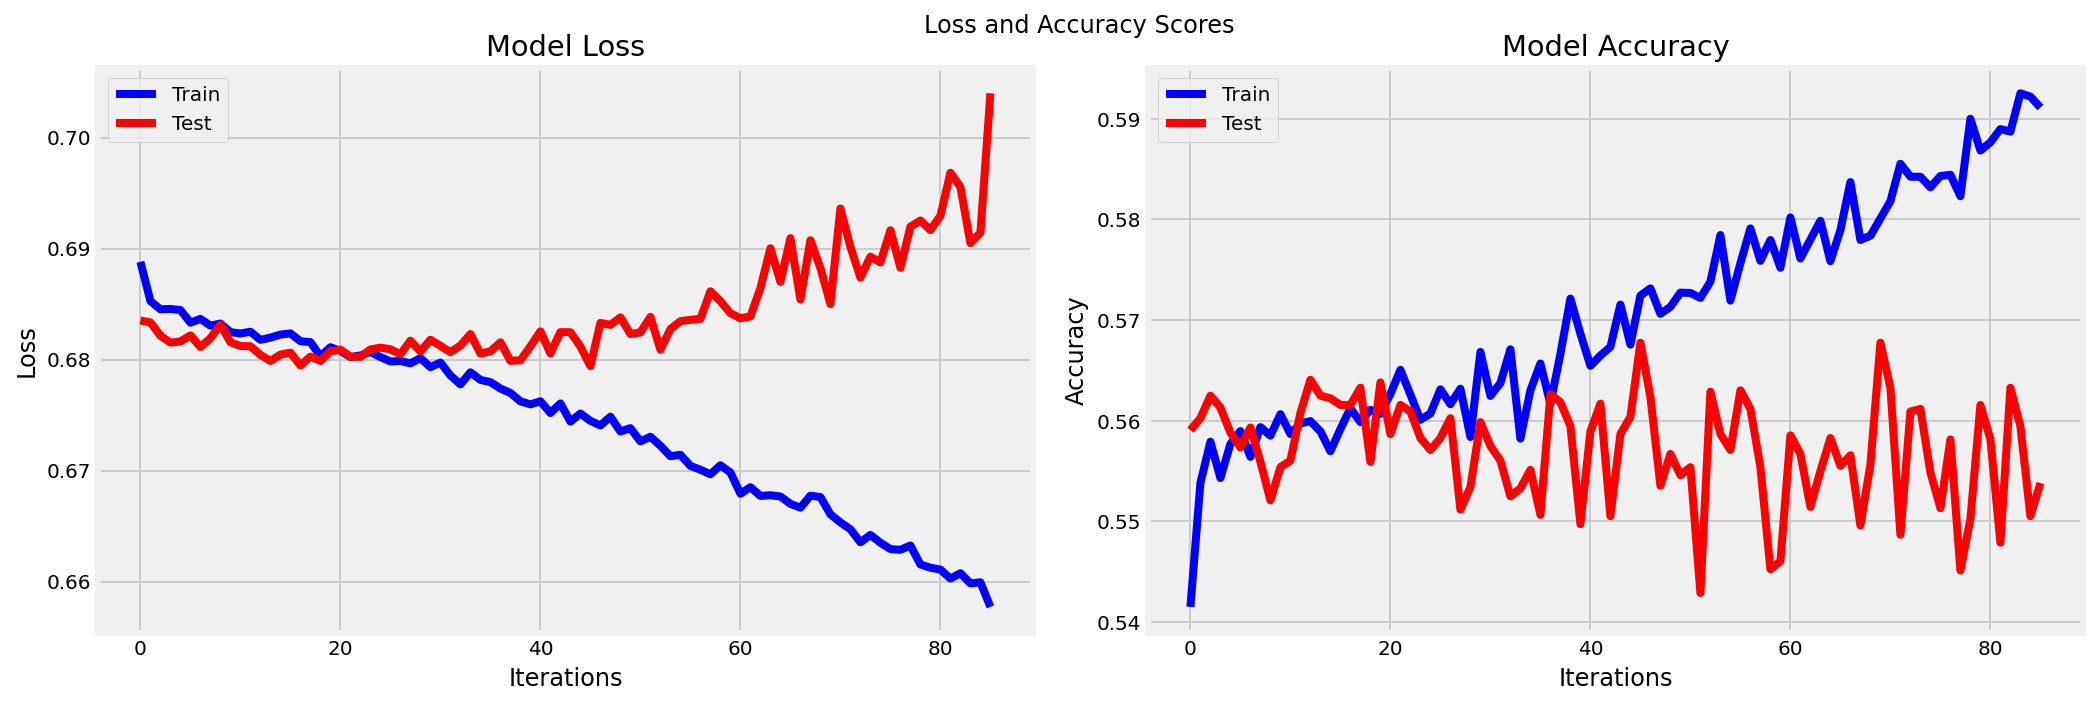


 Baseline Train:  0.47878708149707294 
 Baseline Test:   0.46935017100762955
----------------------------------------
Best Train Score:  0.5817930671577978
Best Test Score:   0.5677453301762694


In [21]:
plot_metrics(history_ltc, ltc_iptr, ltc_ipts, ltc_ytr, ltc_yts)

### XLM

In [22]:
history_xlm = classifier.fit(xlm_iptr, xlm_ytr,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(xlm_ipts, xlm_yts),
                    callbacks=[early_stop, model_checkpoint_callback])

Epoch 1/200
52/52 [==============================] - 3s 57ms/step - loss: 0.6944 - accuracy: 0.5292 - val_loss: 0.6889 - val_accuracy: 0.5360
Epoch 2/200
52/52 [==============================] - 3s 62ms/step - loss: 0.6886 - accuracy: 0.5393 - val_loss: 0.6876 - val_accuracy: 0.5463
Epoch 3/200
52/52 [==============================] - 3s 57ms/step - loss: 0.6880 - accuracy: 0.5408 - val_loss: 0.6877 - val_accuracy: 0.5454
Epoch 4/200
52/52 [==============================] - 3s 57ms/step - loss: 0.6876 - accuracy: 0.5363 - val_loss: 0.6884 - val_accuracy: 0.5402
Epoch 5/200
52/52 [==============================] - 3s 59ms/step - loss: 0.6869 - accuracy: 0.5425 - val_loss: 0.6887 - val_accuracy: 0.5384
Epoch 6/200
52/52 [==============================] - 3s 60ms/step - loss: 0.6865 - accuracy: 0.5436 - val_loss: 0.6899 - val_accuracy: 0.5366
Epoch 7/200
52/52 [==============================] - 3s 62ms/step - loss: 0.6855 - accuracy: 0.5492 - val_loss: 0.6891 - val_accuracy: 0.5321
Epoch 

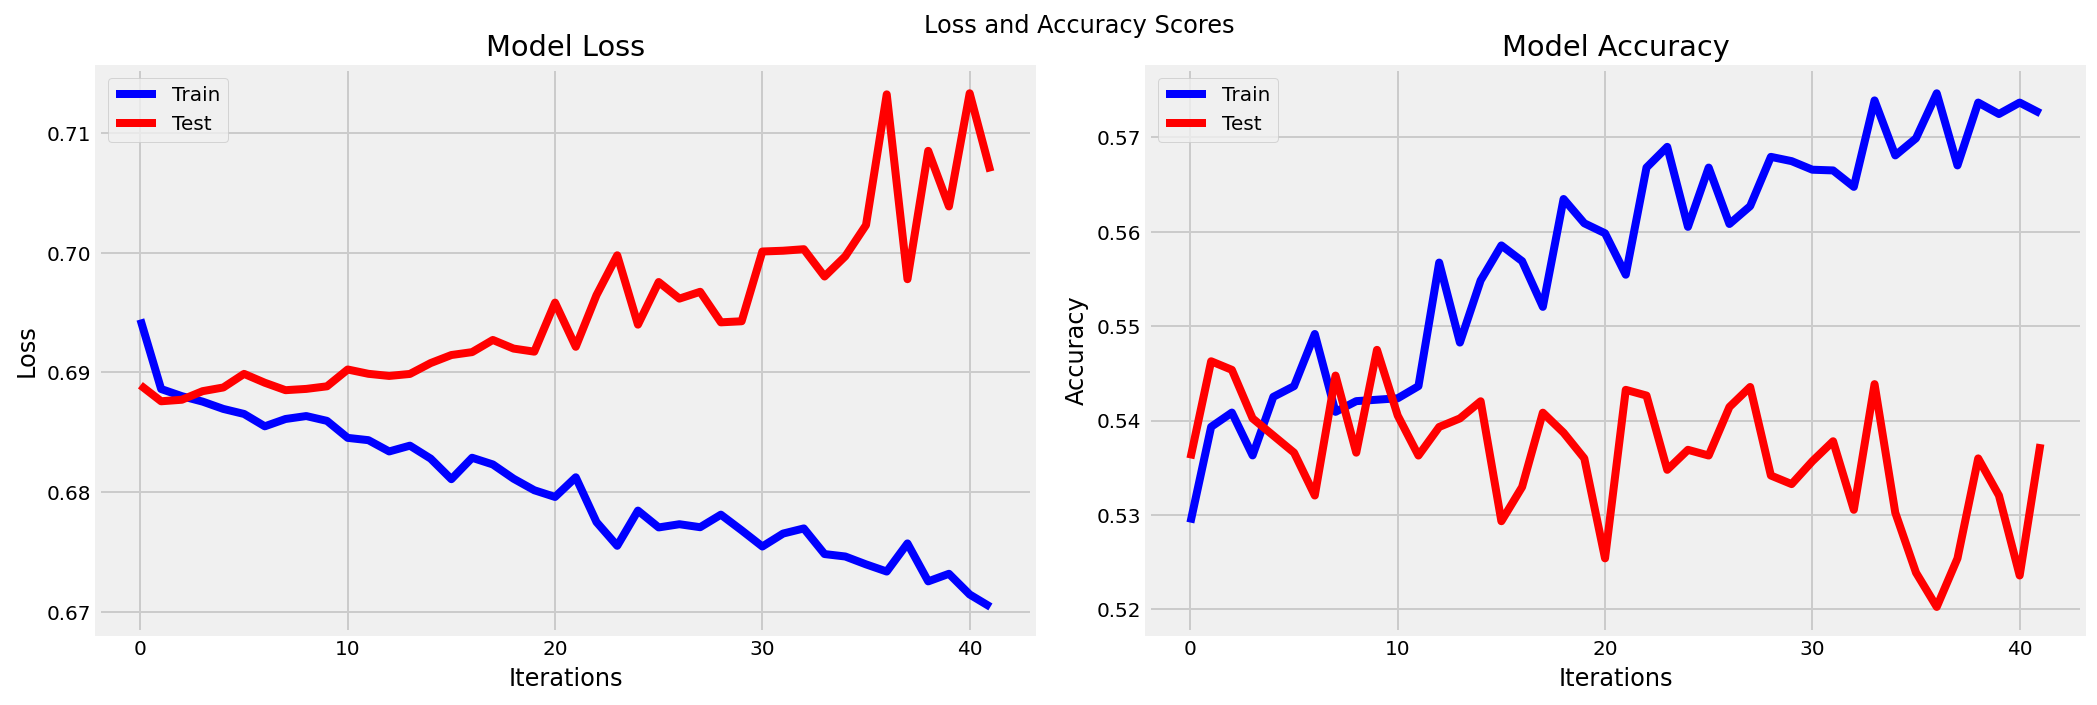


 Baseline Train:  0.4997730711043873 
 Baseline Test:   0.500302480338778
----------------------------------------
Best Train Score:  0.5470499243570348
Best Test Score:   0.5462794918330308


In [23]:
plot_metrics(history_xlm, xlm_iptr, xlm_ipts, xlm_ytr, xlm_yts)

### DASH

In [24]:
history_dash = classifier.fit(dash_iptr, dash_ytr,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(dash_ipts, dash_yts),
                    callbacks=[early_stop, model_checkpoint_callback])

Epoch 1/200
38/38 [==============================] - 2s 52ms/step - loss: 0.6919 - accuracy: 0.5331 - val_loss: 0.6903 - val_accuracy: 0.5320
Epoch 2/200
38/38 [==============================] - 2s 48ms/step - loss: 0.6891 - accuracy: 0.5331 - val_loss: 0.6907 - val_accuracy: 0.5295
Epoch 3/200
38/38 [==============================] - 2s 45ms/step - loss: 0.6875 - accuracy: 0.5409 - val_loss: 0.6908 - val_accuracy: 0.5274
Epoch 4/200
38/38 [==============================] - 2s 49ms/step - loss: 0.6875 - accuracy: 0.5406 - val_loss: 0.6909 - val_accuracy: 0.5270
Epoch 5/200
38/38 [==============================] - 2s 52ms/step - loss: 0.6860 - accuracy: 0.5518 - val_loss: 0.6910 - val_accuracy: 0.5299
Epoch 6/200
38/38 [==============================] - 2s 50ms/step - loss: 0.6863 - accuracy: 0.5481 - val_loss: 0.6915 - val_accuracy: 0.5257
Epoch 7/200
38/38 [==============================] - 2s 50ms/step - loss: 0.6857 - accuracy: 0.5474 - val_loss: 0.6912 - val_accuracy: 0.5295
Epoch 

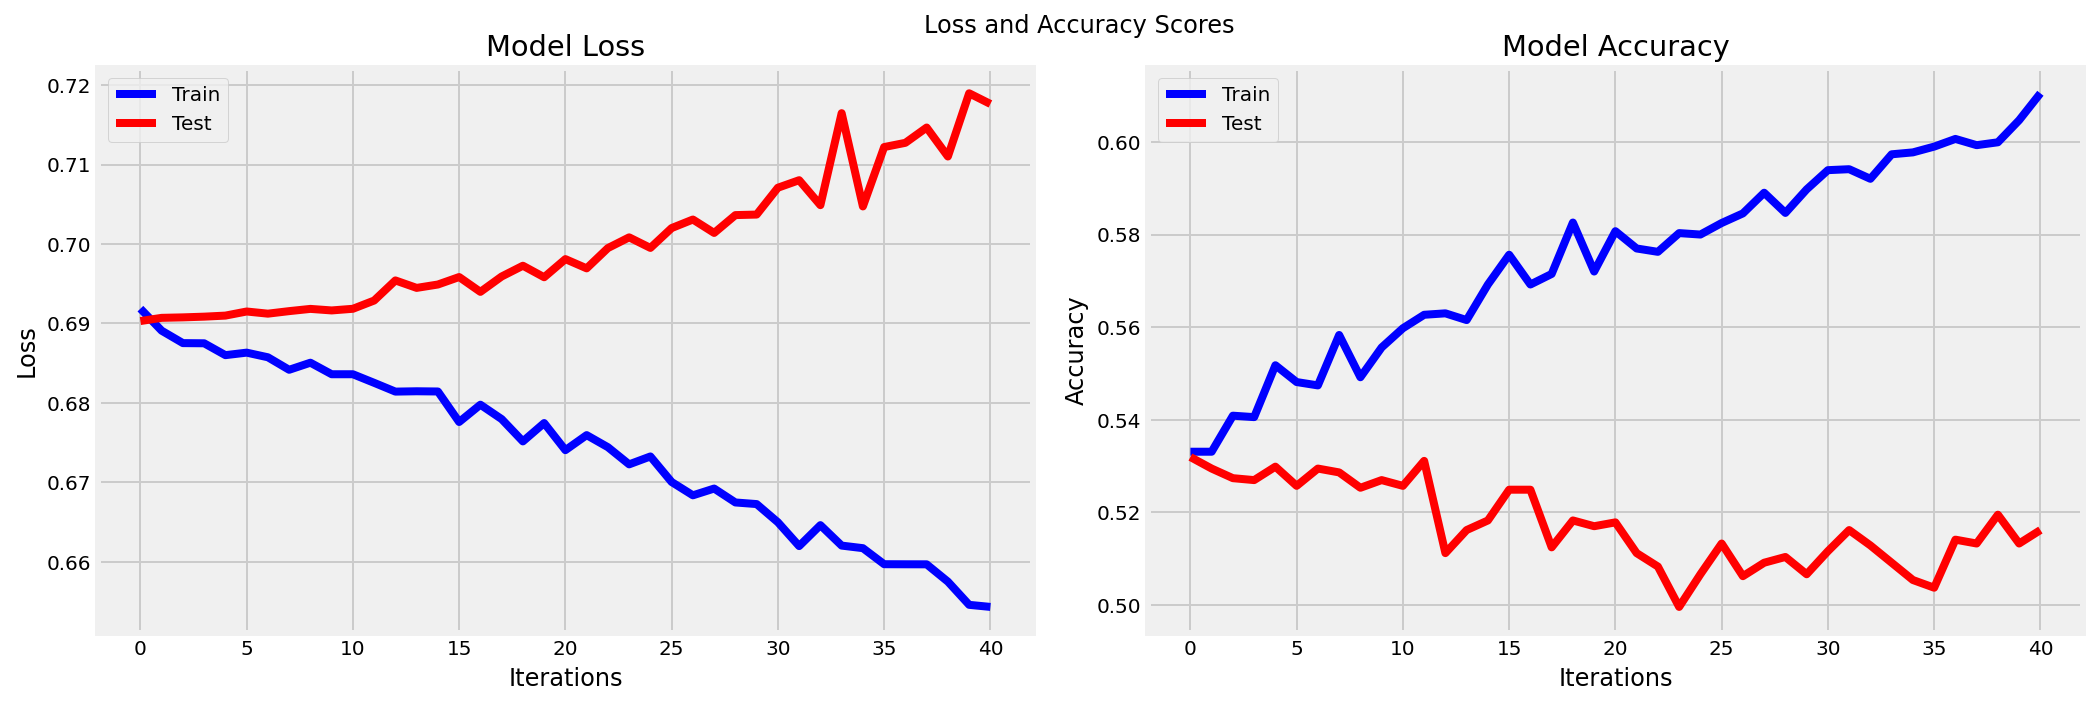


 Baseline Train:  0.5014525835235526 
 Baseline Test:   0.4863070539419087
----------------------------------------
Best Train Score:  0.5448225772981946
Best Test Score:   0.5319502074688797


In [25]:
plot_metrics(history_dash, dash_iptr, dash_ipts, dash_ytr, dash_yts)

### LINK

In [26]:
history_link = classifier.fit(link_iptr, link_ytr,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(link_ipts, link_yts),
                    callbacks=[early_stop, model_checkpoint_callback])

Epoch 1/200
44/44 [==============================] - 3s 58ms/step - loss: 0.6894 - accuracy: 0.5321 - val_loss: 0.6896 - val_accuracy: 0.5342
Epoch 2/200
44/44 [==============================] - 3s 57ms/step - loss: 0.6890 - accuracy: 0.5378 - val_loss: 0.6892 - val_accuracy: 0.5364
Epoch 3/200
44/44 [==============================] - 3s 64ms/step - loss: 0.6868 - accuracy: 0.5453 - val_loss: 0.6889 - val_accuracy: 0.5353
Epoch 4/200
44/44 [==============================] - 3s 62ms/step - loss: 0.6881 - accuracy: 0.5474 - val_loss: 0.6896 - val_accuracy: 0.5321
Epoch 5/200
44/44 [==============================] - 3s 60ms/step - loss: 0.6867 - accuracy: 0.5447 - val_loss: 0.6896 - val_accuracy: 0.5296
Epoch 6/200
44/44 [==============================] - 3s 65ms/step - loss: 0.6870 - accuracy: 0.5483 - val_loss: 0.6895 - val_accuracy: 0.5328
Epoch 7/200
44/44 [==============================] - 3s 66ms/step - loss: 0.6855 - accuracy: 0.5503 - val_loss: 0.6898 - val_accuracy: 0.5325
Epoch 

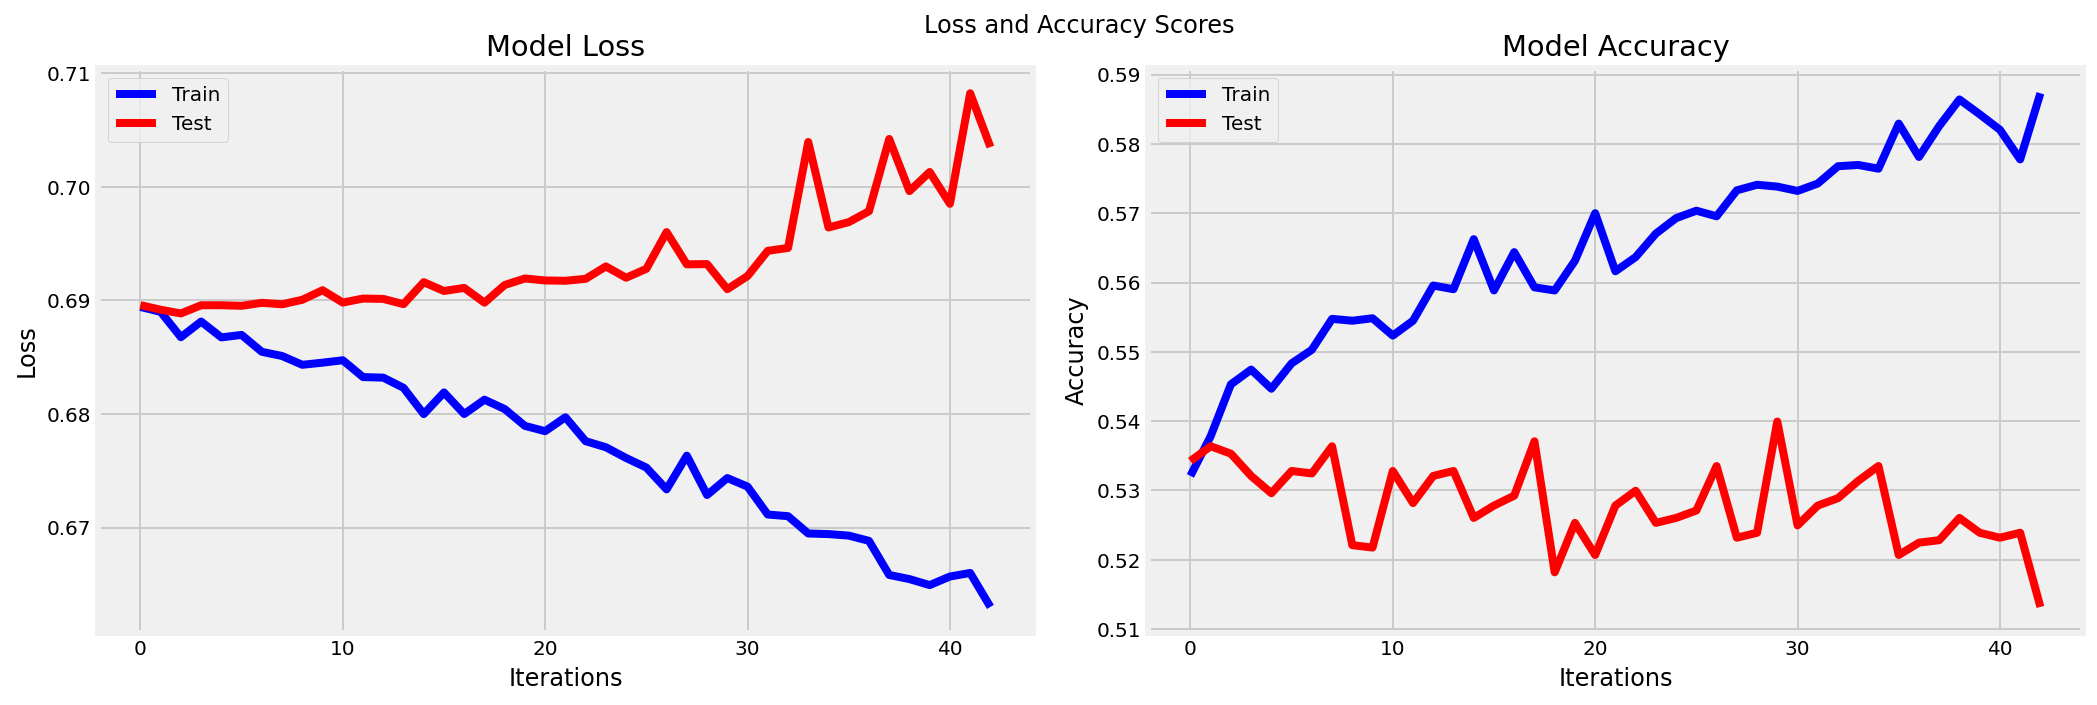


 Baseline Train:  0.4959871589085072 
 Baseline Test:   0.4871611982881598
----------------------------------------
Best Train Score:  0.5484216158373462
Best Test Score:   0.5353067047075606


In [27]:
plot_metrics(history_link, link_iptr, link_ipts, link_ytr, link_yts)

### Comment

- Looks like trying out a Deep Learning model can help to improve the scores, but also not by much (previous notebooks have a ~5% improvement over baseline when measuring accuracy, looks to be around the same here)
- Further tinkering with the model architecture would be needed
- Unfortunately, there's no way to identify feature importances (that I'm aware of, and would likely not make sense anyway)